# M1 Actividad
### Daniel Gutiérrez Gómez A01068056

Dado:
* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

Realiza la siguiente simulación:
* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
* En cada paso de tiempo:
    * Si la celda está sucia, entonces aspira.
    * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido.

* Para un espacio de 100x100, considera los siguientes escenarios:

    * Escenario 1: 1 agente, 90% de celdas sucias.
    * Escenario 2: 2 agentes, 90% de celdas sucias.


## Recopilar la siguiente información durante ejecución
* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
* Porcentaje de celdas limpias después del termino de la simulación.
* Número de movimientos realizados por todos los agentes.

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from typing import Any
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos paquetes para medir el tiempo del algoritmo
import time
import datetime

# Clase del agente de limpieza
class CleaningAgent(Agent):
    #Creación de constructor para el agente
    def __init__(self, id, model):
        super().__init__(id, model)
        self.clean_cells_steps = {key: 0 for key in range(self.model.grid.width)}
        self.count_step = 0
        self.count_cleaned = 0
    
    # Realizar step en cada iteración
    def step(self):
        x, y = self.pos
        # Celda sucia, marcar como limpia
        if self.model.state_floor[x][y] == 0:
            self.model.cleaned_cells += 1
            self.model.state_floor[x][y] = 1
            self.count_cleaned += 1
        else:
            # Obtener vecindades
            neighborRandom = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = True)
            # Obtener vecindades random en base a las vecindades
            (newX, newY) = self.random.choice(neighborRandom)
            # Si es válida la celda con nueva posición random y no hay un agente
            if self.check_edges(newX, newY) and self.model.grid.is_cell_empty((newX, newY)):
                self.model.grid.move_agent(self, (newX, newY))
        self.count_step += 1
        self.clean_cells_steps[self.count_step] = self.count_cleaned
    
    # Realizar checkeo de posición actual válida
    def check_edges(self, x, y):
        return x < self.model.grid.width and x >= 0 and y < self.model.grid.height and y >= 0

# Obtención del estado del suelo
def get_grid(model):
    return np.copy(model.state_floor)

# Determinar si ya está limpio el suelo
def determine_clean(model):
    rows, cols = model.state_floor.shape
    answer_matrix = np.ones((rows, cols))
    return np.array_equal(model.state_floor, answer_matrix)

# Clase para realización del modelo de limpieza
class CleaningModel(Model):
    #Constructor que recibe
    # num agentes
    # ancho
    # altura
    # max de pasos
    # porcentaje de limpias
    # celdas limpiadas
    # estado del piso
    # celdas a cubrir como sucias
    # tiempo max de exe
    # calcular generacion de celdas sucias
    # generar piso de manera random con 90% sucias
    def __init__(self, N, width, height, max_steps, percentage, maxTime):
        self.grid = MultiGrid(width, height, False)
        self.schedule = SimultaneousActivation(self)
        self.num_agents = N
        self.max_steps = max_steps
        self.percentage = percentage
        self.cleaned_cells = 0
        self.state_floor = np.zeros((width, height))
        self.cells_to_cover = 0
        self.maxTime = maxTime
        self.calculate_cells_to_cover()
        self.generate_random_state()
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        
        # Para cada agente posicionar en casilla 1 1 y mantener rastreo multigrid
        for i in range(self.num_agents):
            agent = CleaningAgent(i + 1, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (1, 1))
        
    # Calcular cantidad de celdas a cubrir con unos
    def calculate_cells_to_cover(self):
        self.cells_to_cover = int((self.grid.width * self.grid.height) * (1 - self.percentage))
        
    # Modificación del estado del piso antes de iniciar simulación
    def generate_random_state(self):
        self.cleaned_cells += self.cells_to_cover
        indices = np.random.choice(self.grid.width * self.grid.height, self.cells_to_cover, replace=False)
        self.state_floor.flat[indices] = 1
    
    # Step para guardar información del datacollector y mostrar figura
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [63]:
# Creación de instancia del modelo a ejecutar
MAX_STEPS = 100000
WIDTH = 100
HEIGHT = 100
PERCENTAGE_DIRTY = 0.90
NUM_AGENTS = 10
MAX_TIME = 1000

PD_DATA_FRAME = {}
TIMES_REPEAT_ALGO = 0

while TIMES_REPEAT_ALGO < 7:
    START_TIME = time.time()
    TOTAL_STEPS = 0
    IS_CLEANED = False
    TOTAL_PERCENTAGE_CLEANED = 0.0
    CELLS_COVERED_AGENT = 0
    MODEL = CleaningModel(NUM_AGENTS, WIDTH, HEIGHT, MAX_STEPS, PERCENTAGE_DIRTY, MAX_TIME)
    for i in range(MAX_STEPS):
        MODEL.step()
        if determine_clean(MODEL):
            TOTAL_STEPS += 1
            IS_CLEANED = True
            break
        TOTAL_STEPS += 1
    MAX_STEPS = 100000
    CELLS_COVERED_AGENT = ((MODEL.cleaned_cells - MODEL.cells_to_cover) * 100) / (WIDTH * HEIGHT)
    # Indexando diccionario para dar valores y crear DataFrame
    PD_DATA_FRAME[TIMES_REPEAT_ALGO] = {'Pasos totales: ' : TOTAL_STEPS,
                            'Limpio el espacio' : 'Sí' if IS_CLEANED else 'No',
                            'Celdas limpiadas': MODEL.cleaned_cells,
                            'Porcentaje limpiado por agentes' : CELLS_COVERED_AGENT,
                            'Porcentaje no limpiado' : 90 - CELLS_COVERED_AGENT,
                            'Tiempo tomado' : str(datetime.timedelta(seconds=(time.time() - START_TIME))),
                            'Num agentes' : NUM_AGENTS
                            }
    TIMES_REPEAT_ALGO += 1

# Impresión del total de pasos de ejecución
print('Total de pasos de ejecución para limpiar celdas: ', TOTAL_STEPS if IS_CLEANED else 'No se ha limpiado el espacio completo :(, celdas limpiadas contando el porcentaje inicial:', MODEL.cleaned_cells)

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - START_TIME))))

Total de pasos de ejecución para limpiar celdas:  31938 10000
Tiempo de ejecución: 0:00:06.596273


In [ ]:
# Calculo de celdas limpiadas por el agente
CELLS_COVERED_AGENT = MODEL.cleaned_cells - MODEL.cells_to_cover

# Calcular porcentage de celdas limpias
TOTAL_PERCENTAGE_CLEANED = (CELLS_COVERED_AGENT * 100) / (WIDTH * HEIGHT)
print("Porcentaje de celdas limpiadas: ", TOTAL_PERCENTAGE_CLEANED, " de un 100%")

Porcentaje de celdas limpiadas:  90.01  de un 100%


In [75]:
from datetime import timedelta

# Creación de dataframe para visualizar resultados de manera sencilla
SUM_TOTAL_TIME = timedelta()

# Contar cuantas veces se ha limpiado el espacio completo
SUM_TOTAL_STEPS = sum(item['Pasos totales: ']
                      for item in PD_DATA_FRAME.values() if item['Limpio el espacio'] == 'Sí')

# Contar cuantas veces se ha limpiado el espacio completo
COUNT_IF_SI = sum(1 for item in PD_DATA_FRAME.values() if item['Limpio el espacio'] == 'Sí')

# Obtener promedio de porcentaje no limpiado
PERCENTAGE_AVG = sum(item['Porcentaje no limpiado'] for item in PD_DATA_FRAME.values()) / 7

# Obtener suma de los valores del tiempo tomado para limpiar celdas
for item in PD_DATA_FRAME.values():
    if item['Limpio el espacio'] == 'Sí':
        COUNT_IF_SI += 1
        duration = timedelta(seconds=float(item['Tiempo tomado'].split(':')[-1]))
        SUM_TOTAL_TIME += duration

if COUNT_IF_SI:
    AVERAGE_STEPS_TO_CLEAN = SUM_TOTAL_STEPS / COUNT_IF_SI
    print("Promedio de pasos para limpiar:", AVERAGE_STEPS_TO_CLEAN)
    print("Promedio del tiempo para limpiar:", SUM_TOTAL_TIME.total_seconds() / 7)
else:
    print(PERCENTAGE_AVG)

# Creación de dataframe apartir de diccionario
DATA_FRAME = pd.DataFrame.from_dict(PD_DATA_FRAME)
DATA_FRAME

Promedio de pasos para limpiar: 17358.071428571428
Promedio del tiempo para limpiar: 5.886012857142857


,0,1,2,3,4,5,6
Pasos totales:,39097,30133,31744,35049,32012,43040,31938
Limpio el espacio,Sí,Sí,Sí,Sí,Sí,Sí,Sí
Celdas limpiadas,10000,10000,10000,10000,10000,10000,10000
Porcentaje limpiado por agentes,90.01,90.01,90.01,90.01,90.01,90.01,90.01
Porcentaje no limpiado,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
Tiempo tomado,0:00:07.238765,0:00:06.754761,0:00:03.904865,0:00:04.445689,0:00:05.056149,0:00:07.205944,0:00:06.595917
Num agentes,10,10,10,10,10,10,10


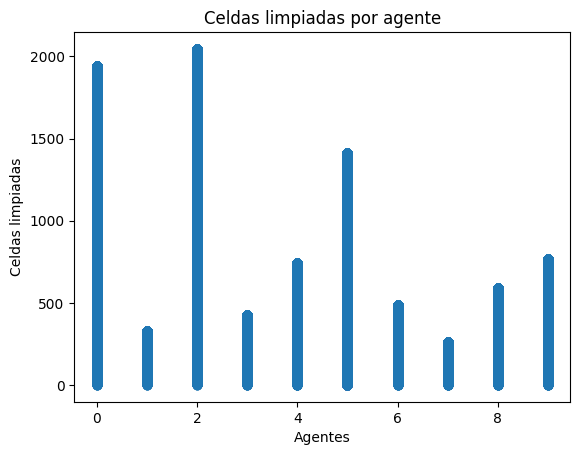

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
# Creación de diccionario de diccionarios
DATA = {}
for agent in range(NUM_AGENTS):
    DATA[agent] = MODEL.schedule.agents[agent].clean_cells_steps

# Creación de DataFrame apartir de un diccionario
DATA_FRAME_CLEAN = pd.DataFrame.from_dict(DATA)

# Reiniciar índices y dar nombre a estos
df_melted = DATA_FRAME_CLEAN.melt(var_name='Agentes', value_name='Pasos', ignore_index=False).reset_index()

# Plot de gráfico
plt.scatter(df_melted['Agentes'], df_melted['Pasos'], marker='o', alpha=0.5)
plt.xlabel('Agentes')
plt.ylabel('Celdas limpiadas')
plt.title('Celdas limpiadas por agente')
plt.show()

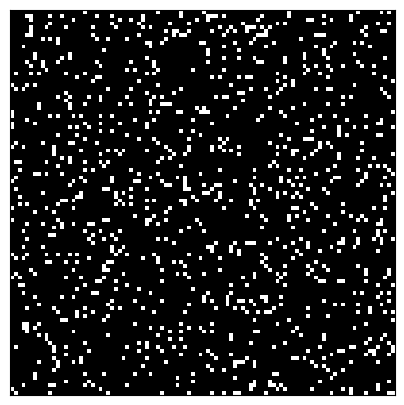

In [87]:
# Obtención de información que nos regresa el recolector del modelo
all_grid = MODEL.datacollector.get_model_vars_dataframe()


fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary_r)

def animate(frame):
    patch.set_data(all_grid.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames=MAX_STEPS)